In [1]:
# Import necessary libraries
import glob
import imageio
import matplotlib.pyplot as plt
import numpy as np
import os
import PIL
from tensorflow.keras import layers
import time
from IPython import display
import tensorflow as tf

### Load MNIST DataSet

In [2]:
(train_images, train_labels), (_, _) = tf.keras.datasets.mnist.load_data()

# for all images in real dataset, we classify as 1
# for all images in fake dataset, we classify as 0

11490434/11490434 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [3]:
train_images.shape   # None, 28, 28, 2 here None is batch size

(60000, 28, 28)

### Normalise and add channel as the dimension
- Reshape and normalise the images
- Reshape to ass to the channel dimension and normalize pixel value to [-1,1]

In [4]:
train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype('float32')
# convert train_images into 4D tensor of shape(num_images, 28, 28, 1)
train_images = (train_images - 127.5) / 127.5
print(train_images.shape)

(60000, 28, 28, 1)


### Create Buffer and Batch size

In [5]:
BUFFER_SIZE = 60000 # dataset size
BATCH_SIZE = 256 # batch size for training

### Shuffle the Images

In [6]:
# create batches of training data with shuffle
train_dataset = tf.data.Dataset.from_tensor_slices(train_images).shuffle(BUFFER_SIZE).batch(BATCH_SIZE)

## Initialise generator Model

In [7]:
# write function to create generator model
def make_generator_model():
  model = tf.keras.Sequential()

  # First layer: Dense layer to project the input latent vector/ noise vector
  model.add(layers.Dense(7*7*256, use_bias=False, input_shape=(100,)))

  # Batch normalization helps in stabilize trainig by normalizing the outputs of previous layer
  model.add(layers.BatchNormalization())

  # leakyReLu activation to allow a small gradient when unit is not active
  model.add(layers.LeakyReLU())

  # Reshape the output to 7x7x256 tensor
  model.add(layers.Reshape((7, 7, 256)))
  # The output shape is (batch_size, 7, 7, 256)

  # First transposed convolution layers
  # Upsample the input to larg feature map
  model.add(layers.Conv2DTranspose(128, (5,5), strides=(1,1), padding='same', use_bias=False))
  # Output shape: (batch size, 7, 7, 128), 128 filter of 5x5 kernel, 128 feature map or depth or filters
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Second transposed convolution layer
  model.add(layers.Conv2DTranspose(64, (5,5), strides=(2,2), padding='same', use_bias=False))
  # output : batch_size, 14, 14, 64
  model.add(layers.BatchNormalization())
  model.add(layers.LeakyReLU())

  # Final transposed conv layer
  model.add(layers.Conv2DTranspose(1, (5,5), strides=(2,2), padding='same', use_bias=False, activation='tanh')) # Normalised image
  # this normalised image will be used in descriminator again

  return model

# generator model
generator = make_generator_model()
generator.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense (Dense)                        │ (None, 12544)               │       1,254,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 12544)               │          50,176 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu (LeakyReLU)              │ (None, 12544)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ reshape (Reshape)                    │ (None, 7, 7, 256)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose (Conv2DTranspose)   │ (None, 7, 7, 128)           │         819,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 7, 7, 128)           │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_1 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_1 (Conv2DTranspose) │ (None, 14, 14, 64)          │         204,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 14, 14, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_2 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_transpose_2 (Conv2DTranspose) │ (None, 28, 28, 1)           │           1,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 2,330,944 (8.89 MB)

 Trainable params: 2,305,472 (8.79 MB)

 Non-trainable params: 25,472 (99.50 KB)

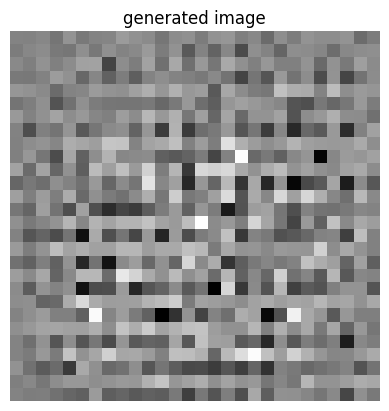

In [8]:
# test our generator, pass random image / noise vector
noise = tf.random.normal([1, 100])
#print(noise)
generated_image = generator(noise, training=False) # generate image from noise
plt.imshow(generated_image[0, :, :, 0], cmap='gray')
plt.title("generated image")
plt.axis('off')
plt.show()

## Discriminator Model

In [9]:
# function for out discriminator model
def make_discriminator_model():
  model = tf.keras.Sequential()

  # First conv layer
  # Downsample the input layer
  model.add(layers.Conv2D(64, (5,5), strides=(2,2), padding='same', input_shape=[28, 28, 1]))
  model.add(layers.LeakyReLU())

  # Dropout helps to prevent overfitting by randomly setting input to zero during training
  model.add(layers.Dropout(0.3))

  # Second conv layer
  model.add(layers.Conv2D(128, (5,5), strides=(2,2), padding='same'))
  model.add(layers.LeakyReLU())
  model.add(layers.Dropout(0.3))

  # Flatten the output and add a final dense layer for classification
  model.add(layers.Flatten())
  model.add(layers.Dense(1)) # 1 indicate the output layer has 1 unit, often used for binary classification

  return model

# discriminator model
discriminator = make_discriminator_model()
discriminator.summary()



/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 14, 14, 64)          │           1,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_3 (LeakyReLU)            │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 14, 14, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 7, 7, 128)           │         204,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ leaky_re_lu_4 (LeakyReLU)            │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 7, 7, 128)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 6272)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │           6,273 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 212,865 (831.50 KB)

 Trainable params: 212,865 (831.50 KB)

 Non-trainable params: 0 (0.00 B)

#### It is important to know loss:
 Discriminator loss - quantifies how well our model is able to distinguish real images from fakes.
- We pass real image and find loss (real los) - pass label as 1
- We pass fake image (generated image) and find loss (fake loss) - label as 0
- Total loss = real loss + fake loss

In [10]:
cross_entropy = tf.keras.losses.BinaryCrossentropy(from_logits=True)

In [11]:
# discriminator loss function
def discriminator_loss(real_output, fake_output):
  real_loss = cross_entropy(tf.ones_like(real_output), real_output) # class 1 for real
  fake_loss = cross_entropy(tf.zeros_like(fake_output), fake_output) # class 0 for fake
  total_loss = real_loss + fake_loss
  return total_loss

Generator loss - quantifies how well it was able to trick the discriminator.

Intutively, if generator is performing well, the discriminator will classify the fake images as real

In [12]:
# generator loss function
def generator_loss(fake_output):
  # as we want to fool discriminator, so we input fake images classifies as real (1)
  return cross_entropy(tf.ones_like(fake_output), fake_output)

### Initialise Optimizers


In [13]:
# Adam optimizer is commonly used for adaptive learning rate and momentum
generator_optimizer = tf.keras.optimizers.Adam(1e-4)
discriminator_optimizer = tf.keras.optimizers.Adam(1e-4)

# both optimizers are different because we will train both neural network separately

In [14]:
# Check Point setup to save models during long training process
checkpoint_dir = './training_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")

# ensure the checkpoint dir exists
if not os.path.exists(checkpoint_dir):
  os.makedirs(checkpoint_dir)

# create a checkpoint object to manage all the objects to be saved
checkpoint = tf.train.Checkpoint(generator_optimizer = generator_optimizer,
                                 discriminator_optimizer = discriminator_optimizer,
                                 generator = generator,
                                 discriminator  = discriminator)

In [15]:
# Now let's setup training parameters
EPOCHS = 100 # Number of epochs to train
noise_dim = 100 # Dimension of the noise vector (latent vector)
num_examples_to_generate = 16 # Number of images to generate

# seed for generating images to visualize process, using same seed allows us to see how generated images evolve over time
seed = tf.random.normal([num_examples_to_generate, noise_dim]) # create tensor with shape [16, 100]
# means it will create 16 noise vectors, each dim 100, filled with random values from standard normal distribution (mean 0 and std deviation 1).


### Training Loop
for every epoch
- generate bunch of random noise
- convert random noise into image using generator
- sample with both real and fake images
- train discriminator
- call discriminator loss
- calculate generator loss
- update both generator and discriminator

GradientTape - API for forward propagation and backward propagation, automatic differntiation, record operations and enable gradient calculations

In [16]:
noise = tf.random.normal([BATCH_SIZE, noise_dim])
noise

<tf.Tensor: shape=(256, 100), dtype=float32, numpy=
array([[-0.31472063, -0.7944408 , -0.20038138, ..., -0.79742914,
        -0.24823563,  0.21384238],
       [ 0.15036447, -0.15527028,  1.0824728 , ...,  1.8203235 ,
        -0.04511467,  0.2737201 ],
       [ 0.09232759, -2.3418427 ,  0.06802652, ...,  0.07525218,
        -0.470646  , -1.6301663 ],
       ...,
       [-1.1586019 ,  0.65893525, -0.927867  , ..., -0.12337893,
        -0.8496631 ,  0.32794124],
       [-0.3767569 , -1.1800961 , -0.4210505 , ..., -1.5127472 ,
        -0.70836264,  0.06470636],
       [-0.1962943 , -1.4101036 ,  0.99833417, ..., -0.1773511 ,
         1.1579442 ,  0.24458773]], dtype=float32)>

In [17]:
generated_images = generator(noise, training=False)
generated_images.shape

TensorShape([256, 28, 28, 1])

In [21]:
## Training step function
# @tf.function helps to compile function faster
@tf.function

def train_step(images):
  # Generate random noise for input to generator
  noise = tf.random.normal([BATCH_SIZE, noise_dim])

  # record operations for automatic differentiation
  with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
    # generate fake images from noise
    generated_images = generator(noise, training=True)

    # Get the disctiminator predictions on real and fake images
    real_output = discriminator(images, training=True)
    fake_output = discriminator(generated_images, training=True)

    # calculate losses for both generator and discriminator
    gen_loss = generator_loss(fake_output)
    disc_loss = discriminator_loss(real_output, fake_output)

  # calculate gradient for generator and discriminator
  gradients_of_generator = gen_tape.gradient(gen_loss, generator.trainable_variables)
  gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

  # Apply gradient to update the weights of generator and discriminator
  generator_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
  discriminator_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

Putting It All Together The train_step function performs the following actions in one training iteration:

- Generate Random Noise.

- Creates a batch of random noise vectors to feed into the generator.

- Generate Fake Images

- Uses the generator to create fake images from the noise.

- Get Discriminator Predictions:

- Feeds real images and fake images into the discriminator to get predictions.

- Calculate Losses.

- Computes the loss for both the generator and discriminator based on their performance.

- Compute Gradients.

- Calculates how the weights should be adjusted to minimize the losses.

- Update Weights.

- Adjusts the weights of both the generator and discriminator using the computed gradients and their respective optimizers.

In [22]:
# Function for generating and saving images during training
def generate_and_save_images(model, epoch, test_input):
  # trainig = False, to ensure all layers run in inference mode
  predictions = model(test_input, training=False)

  # Rescale images from [-1, 1] to [0, 1] for display (0 black, 1 white)
  predictions = (predictions + 1) / 2.0

  # Plot the generated images
  fig = plt.figure(figsize=(4,4))

  for i in range(predictions.shape[0]):
      plt.subplot(4, 4, i+1)
      plt.imshow(predictions[i, :, :, 0], cmap='gray')
      plt.axis('off')

  # save the figure
  plt.savefig('image_at_epoch_{:04d}.png'.format(epoch))
  plt.show()

In [ ]:
# Training function to run training loop

def train(dataset, epoch):
  for epoch in range(EPOCHS):
    start = time.time()

    # Iterate over each batch of images
    for image_batch in dataset:
      train_step(image_batch)

    # generate and save images to visualize the process
    generate_and_save_images(generator, epoch + 1, seed)

    # save the model every 15 epochs
    if (epoch + 1) % 15 == 0:
      checkpoint.save(file_prefix = checkpoint_prefix)

    print('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

  # generate image after final epoch
  generate_and_save_images(generator, EPOCHS, seed)

# start training the GAN
train(train_dataset, EPOCHS)

In [26]:
## gif for better visulalization
anim_file = 'gan.gif'

with imageio.get_writer(anim_file, mode='I') as writer:
  # get the list of images files generated during training
  filenames = glob.glob('image_at_epoch_*.png')
  filenames = sorted(filenames)

  for filename in filenames:
    image = imageio.imread(filename)
    writer.append_data(image)

  # append the last image multiple times for a pause at the end
  for _ in range(10):
    writer.append_data(image)



<ipython-input-26-b2a5274f09de>:10: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  image = imageio.imread(filename)


## Save the model (Generator)

In [27]:
generator.save('generator_model_final.keras')
print("Generator model saved to 'generator_model.h5")

Generator model saved to 'generator_model.h5


## Load the model and generate images
- Generate new images using traiend generator.
- Load the generator.
- Create random noise vectores.
- Pass the vector to the generator.
- Save the output.


Generator model loaded successfully.


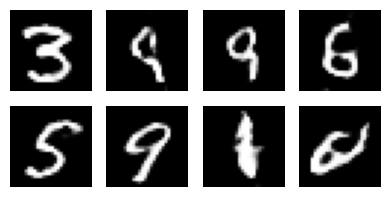

In [29]:
# Load the saved model
generator_trained = tf.keras.models.load_model('generator_model_final.keras')
print("Generator model loaded successfully.")

# Function to generate and display images
def generate_images(generator, num_images=8, noise_dim=100):
  # generate random noise vector
  noise = tf.random.normal([num_images, noise_dim])
  # rescale images from [-1,1] to [0,1]
  generated_images = (generator(noise, training=False) + 1) / 2.0

  # plot
  plt.figure(figsize=(4, 4))
  for i in range(num_images):
    plt.subplot(4, 4, i+1)
    plt.imshow(generated_images[i, :, :, 0], cmap='gray')
    plt.axis('off')
  plt.tight_layout()
  plt.show()

# Generate and display images
generate_images(generator_trained)